#### Import modules and read data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

from sklearn import metrics, preprocessing
from sklearn.model_selection import cross_validate, RepeatedKFold
from sklearn.svm import SVR

In [2]:
df = pd.read_csv(os.getcwd() + '/Data/btc.csv')
df.shape

(4574, 140)

Data source and metrics info: [Coin Metrics](https://tools.coinmetrics.io/)

In [3]:
df.tail()

,date,AdrActCnt,AdrBal1in100KCnt,AdrBal1in100MCnt,AdrBal1in10BCnt,AdrBal1in10KCnt,AdrBal1in10MCnt,AdrBal1in1BCnt,AdrBal1in1KCnt,AdrBal1in1MCnt,...,TxTfrCnt,TxTfrValAdjNtv,TxTfrValAdjUSD,TxTfrValMeanNtv,TxTfrValMeanUSD,TxTfrValMedNtv,TxTfrValMedUSD,VelCur1yr,VtyDayRet180d,VtyDayRet30d
4569,2021-07-08,802085,9377,2210119,15834549,1079,467809,6706534,47,99638,...,696003,206071.673619,6.763202e+09,0.612296,20095.361693,0.004632,152.034447,11.561543,0.046513,0.048756
4570,2021-07-09,818441,9391,2210456,15818519,1078,467950,6702982,48,99597,...,668163,153721.097392,5.213433e+09,0.517916,17565.052466,0.004604,156.158187,11.549880,0.046425,0.044560
4571,2021-07-10,726034,9387,2211377,15826314,1075,468041,6691117,48,99592,...,610588,108118.063501,3.633950e+09,0.570087,19161.163758,0.003739,125.662083,11.538860,0.046016,0.044521
4572,2021-07-11,690684,9382,2211371,15772186,1076,468216,6681615,48,99639,...,489206,115704.744972,3.963864e+09,0.477827,16369.609974,0.003536,121.149154,11.520694,0.045915,0.044646
4573,2021-07-12,838472,9379,2212349,15748278,1075,468317,6684583,47,99675,...,680498,205852.146013,6.820959e+09,0.621649,20598.481278,0.004487,148.677804,11.522382,0.045354,0.044422


Note: Data until 2021-07-12

#### Data processing

In [4]:
df['date'] = pd.to_datetime(df['date'])  # convert date from object to timestamp

df = df.reset_index(drop = True).set_index('date')  # set date as dataframe index

In [5]:
df = df['2013' :]  # fiter to keep data from 2013 onwards 
df.shape

(3115, 139)

Although the first Bitcoin was mined by Satoshi Nakamoto on 2009-01-03, I'm using data ony from 2013 as before that, there wasn't any consistent tracking of BTC metrics.

In [6]:
keep = ['AdrActCnt', 'AdrBal1in10KCnt', 'AdrBalCnt', 'CapMrktCurUSD', 'DiffLast', 'FlowInExNtv', 'FlowOutExNtv', 'HashRate', 'NDF', 'TxCnt', 'PriceUSD']  # attributes to use to create an aggregate growth metric
df = df[keep]

df.head()

,AdrActCnt,AdrBal1in10KCnt,AdrBalCnt,CapMrktCurUSD,DiffLast,FlowInExNtv,FlowOutExNtv,HashRate,NDF,TxCnt,PriceUSD
date,,,,,,,,,,,
2013-01-01,38733,956,1083334,1.415537e+08,2.979637e+06,2025.232892,3971.570665,23.995203,0.414952,32892,13.331371
2013-01-02,40911,956,1087256,1.410655e+08,2.979637e+06,6236.180677,7127.091305,22.662137,0.415285,37619,13.280607
2013-01-03,52539,952,1094193,1.422188e+08,2.979637e+06,7369.853274,7211.470345,23.995203,0.414465,43533,13.384081
2013-01-04,46781,952,1098470,1.429890e+08,2.979637e+06,7791.647509,6683.430401,22.662137,0.414825,47370,13.451721
2013-01-05,53959,957,1105085,1.431181e+08,2.979637e+06,11248.100591,7446.787760,20.884714,0.414961,39811,13.459407


#### Exploratory data analysis

1. PriceUSD

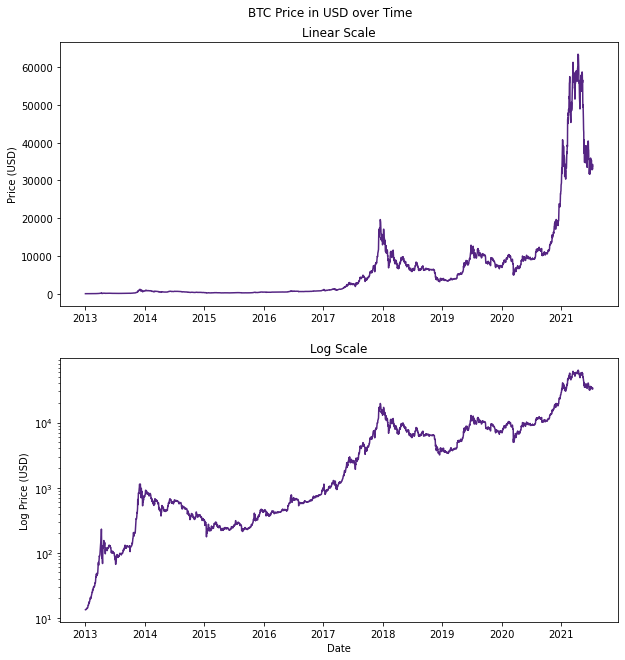

In [7]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex = False, figsize = (10, 10))
fig.suptitle('BTC Price in USD over Time')

ax1.plot(df.index, df['PriceUSD'], color = '#552583')
ax1.set_title('Linear Scale')
ax1.set_ylabel('Price (USD)')

ax2.plot(df.index, df['PriceUSD'], color = '#552583')
ax2.set_yscale('log')
ax2.set_title('Log Scale')
ax2.set_xlabel('Date')
ax2.set_ylabel('Log Price (USD)')

plt.subplots_adjust(top = 0.93)
plt.show()
plt.close()

Observations:

1. The linear scale makes it easy to see the price of BTC increase in late 2017, followed by a drop after that, and the next major increase in 2021. 

2. The log scale makes it easy to see the smaller price changes that took place in 2013 and 2014, the slow increase between 2016 and 2018, while reducing the skewness of the line towards larger values seen in 2018 and 2021. The price change over time looks _almost_ linear. 

In [8]:
def eda_plots(x, y, title, x_lab, y_lab, log_scale = False):  # function to plot attributes from the dataframe
    plt.plot(x, y, color = '#552583')
    if log_scale:
        plt.yscale('log')
    plt.title(title)
    plt.xlabel(x_lab)
    plt.ylabel(y_lab)
    plt.show()
    plt.close()

Transformations applied for some attributes: 
    
* n-day rolling mean: helps smoothen the curve and reduce noise

* log transformation: helps amplify smaller changes that may not be as easy to notice on a linear scale

2. AdrActCnt

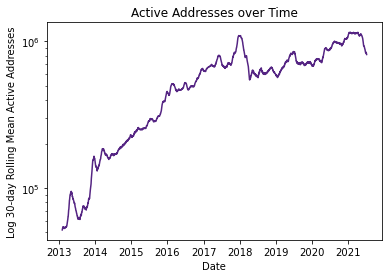

In [9]:
eda_plots(df.index, df['AdrActCnt'].rolling(30).mean(), 'Active Addresses over Time', 'Date', 'Log 30-day Rolling Mean Active Addresses', True)

Observations: As expected, the number of active addresses each day has generally increased over time as Bitcoin became more popular, with noticeabe drops in 2018 and 2021 when BTC prices fell.

3. AdrBal1in10KCnt

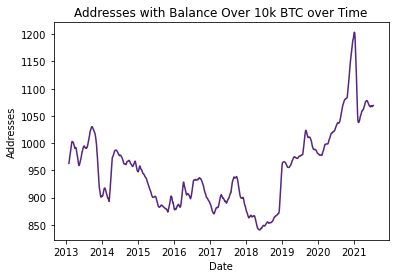

In [10]:
eda_plots(df.index, df['AdrBal1in10KCnt'].rolling(30).mean(), 'Addresses with Balance Over 10k BTC over Time', 'Date', 'Addresses')

Observations: 

4. AdrBalCnt

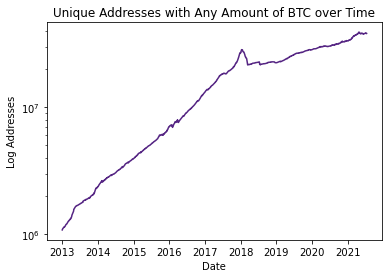

In [11]:
eda_plots(df.index, df['AdrBalCnt'], 'Unique Addresses with Any Amount of BTC over Time', 'Date', 'Log Addresses', True)

Observations: An growing trend with a clear spike visible even on the log scale during the 2018 bull run.

5. CapMrktCurUSD

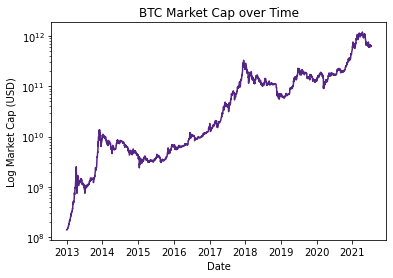

In [12]:
eda_plots(df.index, df['CapMrktCurUSD'], 'BTC Market Cap over Time', 'Date', 'Log Market Cap (USD)', True)

Observations: As market cap is the product of supply and price, this graph is effectively a scaled-up graph of BTC price over time. Market cap will not be used as an input variable for the aggregate growth metric.

6. DiffLast

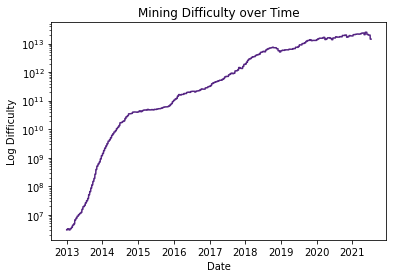

In [13]:
eda_plots(df.index, df['DiffLast'], 'Mining Difficulty over Time', 'Date', 'Log Difficulty', True)

Observations: With an increasing number of miners over time, an increasing difficulty is observed to keep the block time around 10 minutes

7. FlowInExNtv

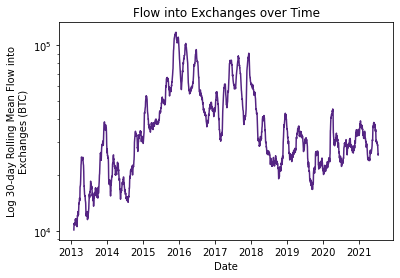

In [14]:
eda_plots(df.index, df['FlowInExNtv'].rolling(30).mean(), 'Flow into Exchanges over Time', 'Date', 'Log 30-day Rolling Mean Flow into\nExchanges (BTC)', True)

8. FlowOutExNtv

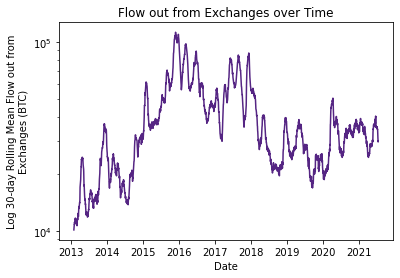

In [15]:
eda_plots(df.index, df['FlowOutExNtv'].rolling(30).mean(), 'Flow out from Exchanges over Time', 'Date', 'Log 30-day Rolling Mean Flow out from\nExchanges (BTC)', True)

9. HashRate

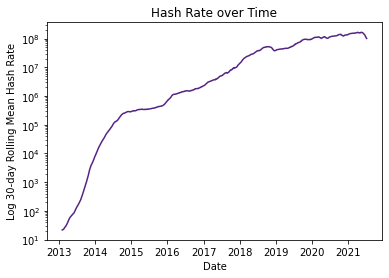

In [16]:
eda_plots(df.index, df['HashRate'].rolling(30).mean(), 'Hash Rate over Time', 'Date', 'Log 30-day Rolling Mean Hash Rate', True)

Observations: As expected, while the absolute values differ, the shape of the plot of the hash rate over time is extremely similar to that of the mining difficulty.

10. NDF

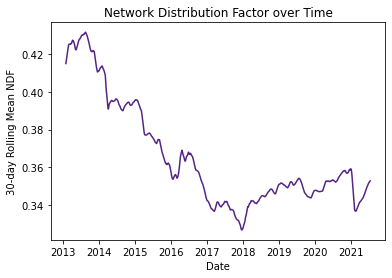

In [17]:
eda_plots(df.index, df['NDF'].rolling(30).mean(), 'Network Distribution Factor over Time', 'Date', '30-day Rolling Mean NDF')

11. TxCnt

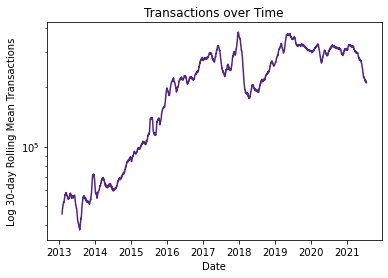

In [18]:
eda_plots(df.index, df['TxCnt'].rolling(30).mean(), 'Transactions over Time', 'Date', 'Log 30-day Rolling Mean Transactions', True)

#### Creating a dataframe with transformed data:

In [19]:
trf_df = df.copy()
trf_df.drop(columns = ['CapMrktCurUSD'], inplace = True)

In [20]:
# apply transformations
trf_df['PriceUSD'] = trf_df['PriceUSD'].rolling(30).mean().apply(lambda x: np.log(x))
trf_df['AdrActCnt'] = trf_df['AdrActCnt'].rolling(30).mean().apply(lambda x: np.log(x))
trf_df['AdrBal1in10KCnt'] = trf_df['AdrBal1in10KCnt'].rolling(30).mean()
trf_df['AdrBalCnt'] = trf_df['AdrBalCnt'].apply(lambda x: np.log(x))
trf_df['DiffLast'] = trf_df['DiffLast'].apply(lambda x: np.log(x))
trf_df['FlowInExNtv'] = trf_df['FlowInExNtv'].rolling(30).mean().apply(lambda x: np.log(x))
trf_df['FlowOutExNtv'] = trf_df['FlowOutExNtv'].rolling(30).mean().apply(lambda x: np.log(x))
trf_df['HashRate'] = trf_df['HashRate'].rolling(30).mean().apply(lambda x: np.log(x))
trf_df['NDF'] = trf_df['NDF'].rolling(30).mean()
trf_df['TxCnt'] = trf_df['TxCnt'].rolling(30).mean().apply(lambda x: np.log(x))

In [21]:
trf_df = trf_df.dropna()  # data from 2013-01-01 to 2013-01-29 is lost due to NaN values as a result of the rolling mean calculation

trf_df.head()

,AdrActCnt,AdrBal1in10KCnt,AdrBalCnt,DiffLast,FlowInExNtv,FlowOutExNtv,HashRate,NDF,TxCnt,PriceUSD
date,,,,,,,,,,
2013-01-30,10.856552,962.866667,13.962655,14.90366,9.222731,9.220818,3.085135,0.415015,10.728642,2.737926
2013-01-31,10.862595,963.833333,13.965563,14.90366,9.268292,9.241076,3.091951,0.415216,10.742836,2.753294
2013-02-01,10.875890,965.033333,13.969542,14.90366,9.292293,9.261529,3.090484,0.415435,10.757061,2.768392
2013-02-02,10.879293,966.533333,13.974113,14.90366,9.303039,9.267931,3.088336,0.415737,10.764832,2.781387
2013-02-03,10.885089,968.266667,13.978434,14.90366,9.297769,9.278405,3.095583,0.416085,10.774023,2.795998


#### Plotting BTC price vs other BTC attributes:

In [22]:
def rel_plots(x, y, title, x_lab, y_lab):  # function to plot PriceUSD vs other attributes
    plt.scatter(x, y, color = '#552583', alpha = 1, s = 1.5)
    plt.title(title)
    plt.xlabel(x_lab)
    plt.ylabel(y_lab)
    plt.show()
    plt.close()

1. AdrActCnt

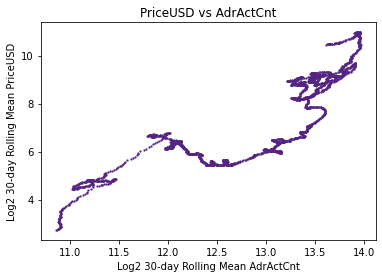

In [23]:
rel_plots(trf_df['AdrActCnt'], trf_df['PriceUSD'], 'PriceUSD vs AdrActCnt', 'Log2 30-day Rolling Mean AdrActCnt', 'Log2 30-day Rolling Mean PriceUSD')

2. AdrBal1in10KCnt

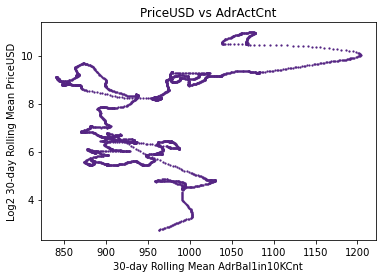

In [24]:
rel_plots(trf_df['AdrBal1in10KCnt'], trf_df['PriceUSD'], 'PriceUSD vs AdrActCnt', '30-day Rolling Mean AdrBal1in10KCnt', 'Log2 30-day Rolling Mean PriceUSD')

3. AdrBalCnt

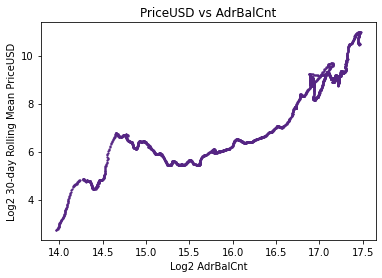

In [25]:
rel_plots(trf_df['AdrBalCnt'], trf_df['PriceUSD'], 'PriceUSD vs AdrBalCnt', 'Log2 AdrBalCnt', 'Log2 30-day Rolling Mean PriceUSD')

4. DiffLast

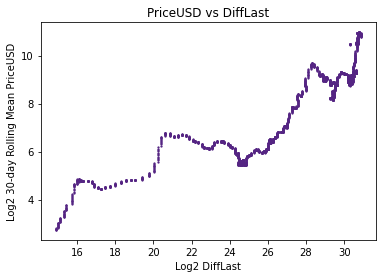

In [26]:
rel_plots(trf_df['DiffLast'], trf_df['PriceUSD'], 'PriceUSD vs DiffLast', 'Log2 DiffLast', 'Log2 30-day Rolling Mean PriceUSD')

5. FlowInExtNtv

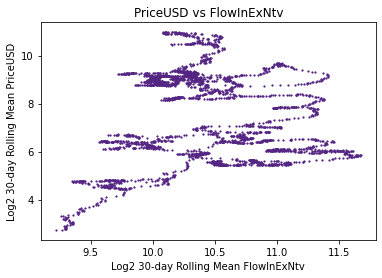

In [27]:
rel_plots(trf_df['FlowInExNtv'], trf_df['PriceUSD'], 'PriceUSD vs FlowInExNtv', 'Log2 30-day Rolling Mean FlowInExNtv', 'Log2 30-day Rolling Mean PriceUSD')

6. FlowOutExtNtv

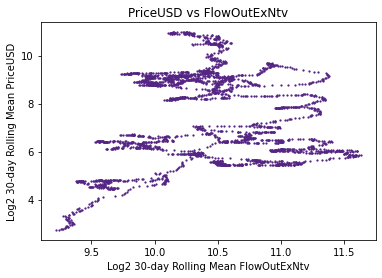

In [28]:
rel_plots(trf_df['FlowOutExNtv'], trf_df['PriceUSD'], 'PriceUSD vs FlowOutExNtv', 'Log2 30-day Rolling Mean FlowOutExNtv', 'Log2 30-day Rolling Mean PriceUSD')

7. HashRate

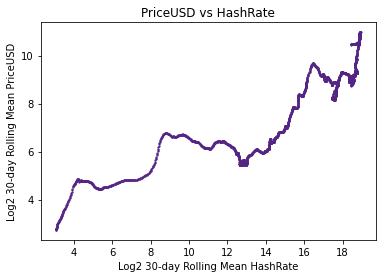

In [29]:
rel_plots(trf_df['HashRate'], trf_df['PriceUSD'], 'PriceUSD vs HashRate', 'Log2 30-day Rolling Mean HashRate', 'Log2 30-day Rolling Mean PriceUSD')

8. NDF

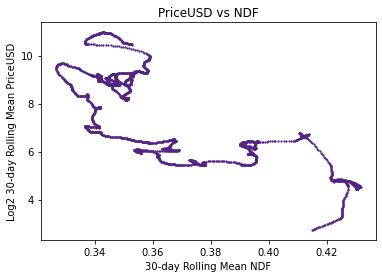

In [30]:
rel_plots(trf_df['NDF'], trf_df['PriceUSD'], 'PriceUSD vs NDF', '30-day Rolling Mean NDF', 'Log2 30-day Rolling Mean PriceUSD')

9. TxCnt

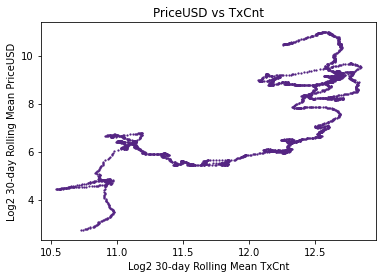

In [32]:
rel_plots(trf_df['TxCnt'], trf_df['PriceUSD'], 'PriceUSD vs TxCnt', 'Log2 30-day Rolling Mean TxCnt', 'Log2 30-day Rolling Mean PriceUSD')

#### Correlation matrix:

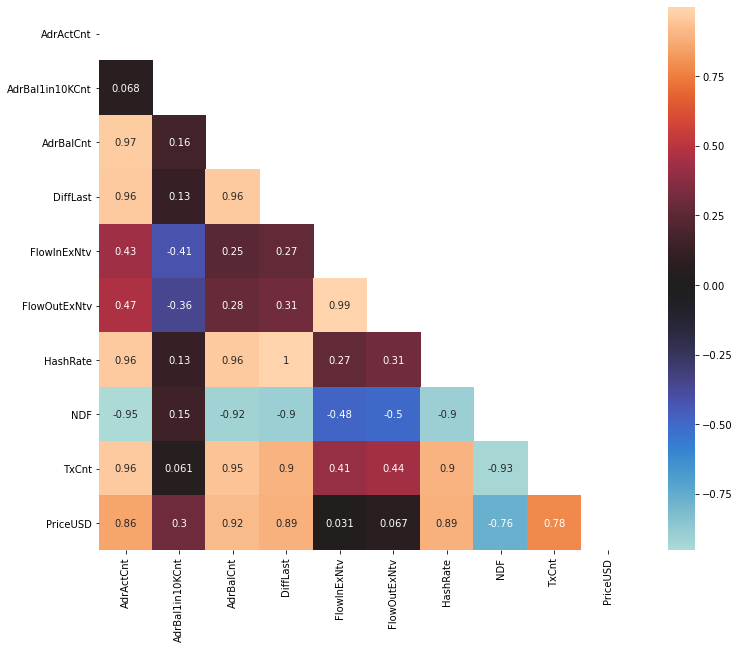

In [33]:
corr_matrix = trf_df.corr()

mask = np.triu(np.ones_like(corr_matrix, dtype = bool))

plt.figure(figsize = (12, 10))
sns.heatmap(corr_matrix, mask = mask, annot = True, center = 0)
plt.show()
plt.close()

#### An aggregate growth metric for Bitcoin

1. Using a single attribute

HashRate has a high correlation value (0.89), hence we can attempt to use a **hash ribbon** as an indicator.

Miner capitulation occurs when Bitcoin mining is no longer profitable. Due to the emergence of mining pools and other large-scale mining centres, a short-term slump in BTC price will not lead to a drastic drop in hash rate in the network.

When the 30-day moving average of the hash rate crosses above the 60-day moving average, the hash ribbon indicator tends to signal the end of miner capitulation, and a return to a growing market.

Note: Since we need to calculate a 60-day rolling average too, we will use the original dataframe _df_ for this metric. Using the transformed HashRate column to calculate the 60-day average is mathematically incorrect.

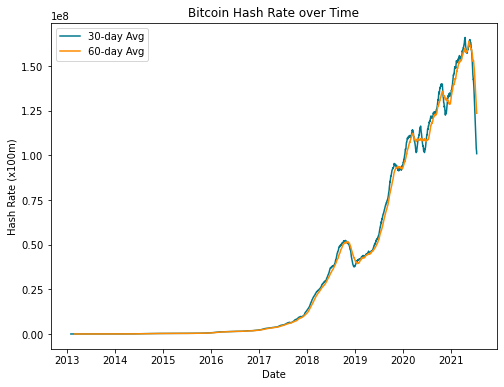

In [34]:
plt.figure(figsize = (8, 6))

plt.plot(df.index, df['HashRate'].rolling(30).mean(), color = '#00788c', label = '30-day Avg')
plt.plot(df.index, df['HashRate'].rolling(60).mean(), color = '#ff8b00', label = '60-day Avg')
# plt.yscale('log')
plt.title('Bitcoin Hash Rate over Time')
plt.xlabel('Date')
plt.ylabel('Hash Rate (x100m)')
plt.legend()
plt.show()
plt.close()

2017 was when the hash rate increased significantly. Replotting the same graph from 2017 onwards and overlaying price:

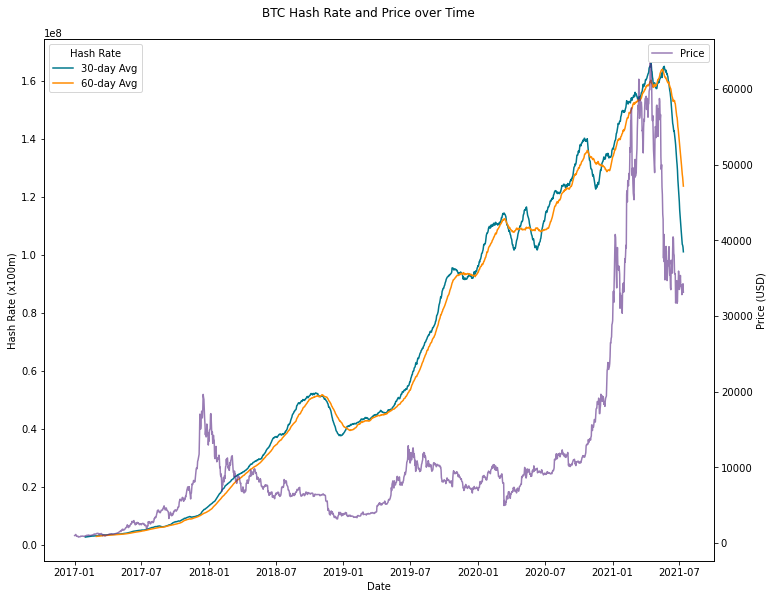

In [35]:
year = '2017'

fig, ax1 = plt.subplots(figsize = (12, 9))
fig.suptitle('BTC Hash Rate and Price over Time')

ax1.plot(df[year :].index, df[year :]['HashRate'].rolling(30).mean(), color = '#00788c', label = '30-day Avg')
ax1.plot(df[year :].index, df[year :]['HashRate'].rolling(60).mean(), color = '#ff8b00', label = '60-day Avg')
ax1.set_xlabel('Date')
ax1.set_ylabel('Hash Rate (x100m)')
# ax1.grid()
plt.legend(title = 'Hash Rate')

ax2 = ax1.twinx()
ax2.plot(df[year :].index, df[year :]['PriceUSD'], color = '#552583', alpha = 0.6, label = 'Price')
ax2.set_ylabel('Price (USD)')
# ax2.grid()
plt.legend()

plt.subplots_adjust(top = 0.93)
plt.show()
plt.close()

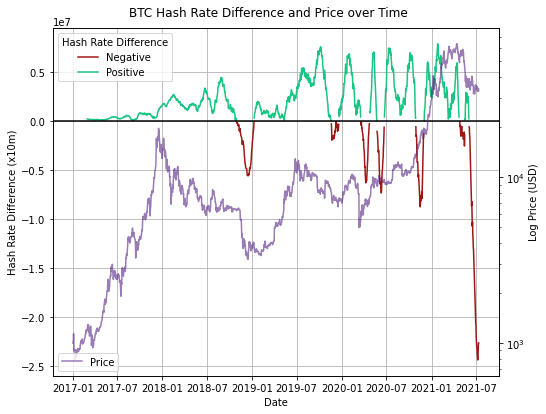

In [36]:
avg_diff = (df[year :]['HashRate'].rolling(30).mean() - df[year :]['HashRate'].rolling(60).mean()).dropna()

upper = np.ma.masked_where(avg_diff < 0, avg_diff)  # > 0 i.e. upper values are masked
lower = np.ma.masked_where(avg_diff > 0, avg_diff)  # < 0 i.e. lower values are masked 

fig, ax1 = plt.subplots(figsize = (8, 6))
fig.suptitle('BTC Hash Rate Difference and Price over Time')

ax1.plot(avg_diff.index, lower, color = '#9e1717', label = 'Negative')
ax1.plot(avg_diff.index, upper, color = '#19c582', label = 'Positive')
ax1.axhline(0, color = '#000000')
ax1.grid()
ax1.set_xlabel('Date')
ax1.set_ylabel('Hash Rate Difference (x10m)')
plt.legend(title = 'Hash Rate Difference', loc = 2)  # 30-day rolling avg - 60-day rolling avg of hash rate

ax2 = ax1.twinx()
ax2.plot(df[year :].index, df[year :]['PriceUSD'], color = '#552583', alpha = 0.6, label = 'Price')
ax2.set_yscale('log')
ax2.set_xlabel('Date')
ax2.set_ylabel('Log Price (USD)')
plt.legend(loc = 3)

plt.xticks(rotation = 90)
plt.subplots_adjust(top = 0.93)
plt.show()
plt.close()

From this graph, we can see that when the hash rate difference is negative, the price of BTC is dropping, and tends to be lower than its recent previous value. 

Hence, using hash rates to create a hash ribbon is simple, yet generally effective metric for BTC price growth. 

2. Using multiple attributes

First, we normalise the data. This is done to ensure that no feature creates a bias in the models due to excessively large or small values. The range [1, 2] was selected as the data will later have log transformations applied, and log 0 is undefined, and the log of any number less than 1 is negative.

In [37]:
min_max_scaler = preprocessing.MinMaxScaler(feature_range = (1, 2))  # using min-max normalisation, the data range is now [1, 2]
scaled_data = min_max_scaler.fit_transform(df.values)
normal_df = pd.DataFrame(scaled_data, columns = df.columns).set_index(df.index).drop(columns = ['CapMrktCurUSD'])  # normalised dataframe

normal_df.tail()

,AdrActCnt,AdrBal1in10KCnt,AdrBalCnt,DiffLast,FlowInExNtv,FlowOutExNtv,HashRate,NDF,TxCnt,PriceUSD
date,,,,,,,,,,
2021-07-08,1.574917,1.605769,1.980104,1.573455,1.100093,1.097236,1.499659,1.271469,1.424612,1.517187
2021-07-09,1.587235,1.603365,1.979695,1.573455,1.096963,1.067979,1.470902,1.270318,1.413110,1.534453
2021-07-10,1.517639,1.596154,1.980521,1.573455,1.039272,1.025300,1.578742,1.267750,1.350076,1.529661
2021-07-11,1.491015,1.598558,1.978576,1.573455,1.043016,1.032748,1.449334,1.268006,1.278897,1.539869
2021-07-12,1.602322,1.596154,1.978550,1.573455,1.104163,1.090173,1.452929,1.265075,1.416896,1.522162


Applying the same transformations as earlier:

In [38]:
normal_df['PriceUSD'] = normal_df['PriceUSD'].rolling(30).mean().apply(lambda x: np.log(x))
normal_df['AdrActCnt'] = normal_df['AdrActCnt'].rolling(30).mean().apply(lambda x: np.log(x))
normal_df['AdrBal1in10KCnt'] = normal_df['AdrBal1in10KCnt'].rolling(30).mean()
normal_df['AdrBalCnt'] = normal_df['AdrBalCnt'].apply(lambda x: np.log(x))
normal_df['DiffLast'] = normal_df['DiffLast'].apply(lambda x: np.log(x))
normal_df['FlowInExNtv'] = normal_df['FlowInExNtv'].rolling(30).mean().apply(lambda x: np.log(x))
normal_df['FlowOutExNtv'] = normal_df['FlowOutExNtv'].rolling(30).mean().apply(lambda x: np.log(x))
normal_df['HashRate'] = normal_df['HashRate'].rolling(30).mean().apply(lambda x: np.log(x))
normal_df['NDF'] = normal_df['NDF'].rolling(30).mean()
normal_df['TxCnt'] = normal_df['TxCnt'].rolling(30).mean().apply(lambda x: np.log(x))

normal_df = normal_df.dropna()

normal_df.head()

,AdrActCnt,AdrBal1in10KCnt,AdrBalCnt,DiffLast,FlowInExNtv,FlowOutExNtv,HashRate,NDF,TxCnt,PriceUSD
date,,,,,,,,,,
2013-01-30,0.009848,1.326603,0.001987,0.0,0.038893,0.024839,1.983602e-08,1.833553,0.032625,0.000034
2013-01-31,0.010082,1.328926,0.002076,0.0,0.041113,0.025666,2.058912e-08,1.835376,0.033973,0.000038
2013-02-01,0.010603,1.331811,0.002198,0.0,0.042322,0.026517,2.042665e-08,1.837362,0.035342,0.000042
2013-02-02,0.010737,1.335417,0.002339,0.0,0.042872,0.026787,2.018907e-08,1.840099,0.036097,0.000045
2013-02-03,0.010967,1.339583,0.002473,0.0,0.042602,0.027232,2.099251e-08,1.843264,0.036997,0.000049


In [39]:
selected = ['AdrActCnt', 'AdrBalCnt', 'HashRate', 'NDF', 'TxCnt', 'PriceUSD']  # selected attributes for the model

model_df = normal_df[selected]

X, Y = model_df[model_df.columns[: -1]], model_df[model_df.columns[-1]]

X.shape, Y.shape

((3086, 5), (3086,))

In [40]:
cv = RepeatedKFold(n_splits = 10, n_repeats = 3, random_state = 42)

In [41]:
svr_poly = SVR(kernel = 'poly')

scoring = ['r2', 'neg_mean_absolute_error', 'neg_mean_squared_error']

scores = cross_validate(svr_poly, X, Y, scoring = scoring, cv = cv, return_estimator = True)

In [42]:
scores['test_r2'].mean()

0.8377528143823204

https://davidmathlogic.com/colorblind/#%23552583-%2300788c-%23ff8b00

https://davidmathlogic.com/colorblind/#%23552583-%239E1717-%2319C582